# ReACT with Interact

For the following example you need the Pyhton wrapper for CAMB installed. The easiest way to do this is to use the `conda` package:

`conda install camb -c conda-forge`

In [1]:
import numpy as np
import camb

%matplotlib inline
import matplotlib.pyplot as plt

import pyreact
#print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Set the cosmology and let CAMB compute the linear power spectrum.

In [2]:
Omega_c = 0.2598
Omega_b = 0.0482
h = 0.678
n_s = 0.966 
A_s = 2.112e-9
m_nu = 0.0
w0 = -1.1
w_a = 0.0


# Model selection and parameter (1:GR, 2:f(R), 3:DGP, 4:quintessence with interaction, 5:CPL with interaction)
mymodel = "quintessence with interaction"
xi_ds = 10.0   # dark scattering interaction term
Omega_rc = 0.0
massloop = 50

p = camb.CAMBparams(WantTransfer=True, 
                    Want_CMB=False, Want_CMB_lensing=False, DoLensing=False, 
                    NonLinear="NonLinear_none",
                    WantTensors=False, WantVectors=False, WantCls=False, WantDerivedParameters=False,
                    want_zdrag=False, want_zstar=False, DarkEnergyModel="fluid")
    
p.set_cosmology(H0=h*100, ombh2=Omega_b*h**2, omch2=Omega_c*h**2, omk=0, mnu=m_nu)
p.set_initial_power(camb.initialpower.InitialPowerLaw(As=A_s, ns=n_s))
p.set_dark_energy(w=w0,wa=w_a)

p.set_matter_power(redshifts=np.linspace(0.0, 10.0, 64, endpoint=True)[::-1],
                   kmax=10.0, nonlinear=False)

r = camb.get_results(p)
sigma_8 = r.get_sigma8()[-1]
k_lin, z_lin, pofk_lin_camb = r.get_matter_power_spectrum(minkh=1e-4, maxkh=10.0, npoints=128)

Omega_v = r.omega_de + r.get_Omega("photon") + r.get_Omega("neutrino")
Omega_m = p.omegam

Now run ReACT to get the reaction and the modified gravity linear power spectrum that will get used by HMCode.

In [3]:
react = pyreact.ReACT()

# Only compute the reaction up to z=2.5
z_lin = np.array(z_lin)
z_react = z_lin[z_lin < 2.5]


R, pofk_lin_MG_react,sigma_8_MG = react.compute_reaction(
                                h, n_s, Omega_m, Omega_b, sigma_8, z_react, k_lin, pofk_lin_camb[0], model=mymodel, 
                                fR0=0, Omega_rc=Omega_rc, w=w0, wa=w_a, xi = xi_ds, 
                                is_transfer=False, mass_loop=massloop,
                                verbose=True)  


Now make some plots!

Text(0.5, 1.0, 'z = 0, $\\xi$ = 10.0')

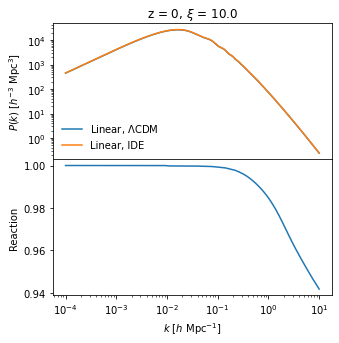

In [4]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 5))
fig.subplots_adjust(hspace=0)

ax[0].loglog(k_lin, pofk_lin_camb[0], label="Linear, $\Lambda$CDM")
ax[0].loglog(k_lin, pofk_lin_MG_react[0], label="Linear, IDE")

ax[1].semilogx(k_lin, R[0])

ax[0].legend(frameon=False)

ax[0].set_ylabel("$P(k)$ [$h^{-3}$ Mpc$^3$]")
ax[1].set_ylabel("Reaction")
ax[1].set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

ax[0].set_title(f"z = 0, $\\xi$ = {xi_ds}")


## Get MG non-linear power spectrum

For this you need HMCode, which can be downloaded from:

```
pip install git+https://github.com/alexander-mead/HMcode@pyhmcode  
```

In [5]:
import pyhmcode as hmcode

In [6]:
hmc = hmcode.Cosmology()

# Set HMcode internal cosmological parameters
hmc.om_m = Omega_c+Omega_b
hmc.om_b = Omega_b
hmc.om_v = 1.-(Omega_c+Omega_b)
hmc.h = h
hmc.ns = n_s
hmc.sig8 = sigma_8
hmc.m_nu = m_nu

# Set the linear power spectrum for HMcode
hmc.set_linear_power_spectrum(k_lin, np.asarray(z_re), pofk_lin_MG_react)

# Set the halo model in HMcode
# Options: HMcode2015, HMcode2016, HMcode2020
hmod = hmcode.Halomodel(hmcode.HMcode2020, verbose=False)

# Power spectrum calculation
Pk_hm = hmcode.calculate_nonlinear_power_spectrum(hmc, hmod, verbose=False)


ValueError: Shape mismatch between k, z, pofk_lin: (128,), (64,), (16, 128)

In [ ]:
plt.loglog(k_lin, Pk_hm[0])
plt.loglog(k_lin, Pk_hm[0]*R[0])